# Análise de Estrutura Secundária de Variantes — DRD4
Este notebook implementa um pipeline reprodutível para comparar previsões de estrutura secundária (SS) entre variantes da proteína DRD4.

Principais objetivos:
- Ler arquivos `.ss2` (estados H/E/C e probabilidades P(C), P(H), P(E)).
- Usar `NM_000797.4` como sequência de referência para indexação (pressupõe que os arquivos `.ss2` já estão alinhados entre si).
- Calcular métricas por posição (concordância estrita, consenso probabilístico, entropia, similaridade de cosseno, transições).
- Agregar métricas em janelas móveis e resumir regiões relevantes; gerar gráficos e tabelas exportáveis.

Premissas e comportamento em casos especiais:
- Entrada: arquivos `.ss2` alinhados entre si; se houver indels, as linhas devem já corresponder à mesma posição de referência.
- Gaps/posições ausentes: o código atual assume que cada arquivo tem a mesma quantidade de linhas; posições faltantes devem ser preenchidas previamente ou tratadas antes da análise.
- A ordem das variantes é a lista `variant_names` carregada do diretório `secondary_struct/`; algumas métricas (ex.: transições) contam mudanças nessa ordem — se desejar outra ordem, reindexe `variant_names` antes de rodar.

Saídas principais:
- `df_metricas`: DataFrame por posição com: pos, aa_ref, concordancia_estrita, media_P_C, media_P_H, media_P_E, entropia, media_similaridade_cosseno, transicoes.
- `df_janela`: DataFrame com agregados por janela móvel (start, end, media_concordancia_estrita, media_entropia, media_similaridade_cosseno, media_transicoes).
- Figuras: gráficos de linha, mapa de calor da entropia e barras de transições (salváveis com células de exportação).

Terminologia usada neste notebook:
- *Concordância estrita*: proporção (0/1 por posição) indicando se todas as variantes concordam no estado secundário naquela posição.
- *Consenso probabilístico*: médias das probabilidades (P_C, P_H, P_E) entre variantes na posição.
- *Entropia*: entropia de Shannon (base 2) do vetor de probabilidades médias — mede incerteza/discordância.
- *Similaridade de cosseno*: média das similaridades de cosseno pairwise entre vetores de probabilidade das variantes (valor máximo=1, mínimo≈0).

Use as células em ordem e ajuste parâmetros (p.ex. tamanho da janela) conforme necessário para suas análises.

In [3]:
# Imports e configurações globais
from pathlib import Path
from typing import Dict, List, Mapping, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [4]:
# Leitura dos arquivos .ss2 alinhados e validações básicas
data_dir = Path('secondary_struct')
ss2_paths = sorted(data_dir.glob('*.ss2'))
if not ss2_paths:
    raise FileNotFoundError("Nenhum arquivo .ss2 encontrado em secondary_struct/")
ref_name = 'NM_000797.4'
def read_ss2(path: Path) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        sep=r"\s+",
        comment='#',
        header=None,
        names=['pos', 'aa', 'ss', 'P_C', 'P_H', 'P_E'],
        engine='python',
    )
    df = df.sort_values('pos').reset_index(drop=True)
    df['pos'] = df['pos'].astype(int)
    prob_cols = ['P_C', 'P_H', 'P_E']
    df[prob_cols] = df[prob_cols].astype(float)
    df['aa'] = df['aa'].str.upper()
    df['ss'] = df['ss'].str.upper()
    df['variant'] = path.stem
    return df
all_data: Dict[str, pd.DataFrame] = {path.stem: read_ss2(path) for path in ss2_paths}
if ref_name not in all_data:
    raise KeyError(f"Sequência de referência '{ref_name}' não encontrada em secondary_struct/")
variant_names: List[str] = [path.stem for path in ss2_paths]
variant_names = [ref_name] + [name for name in variant_names if name != ref_name]
reference_positions = all_data[ref_name]['pos'].to_numpy()
reference_length = len(reference_positions)
for name, df in all_data.items():
    if len(df) != reference_length:
        raise ValueError(f"Arquivo {name} possui {len(df)} linhas; esperado {reference_length}.")
    if not np.array_equal(df['pos'].to_numpy(), reference_positions):
        raise ValueError(f"Posições não alinham entre referência e variante {name}.")
    for prob_col in ['P_C', 'P_H', 'P_E']:
        if df[prob_col].isna().any():
            raise ValueError(f"Probabilidades ausentes detectadas em {name}:{prob_col}.")
print(f"{len(variant_names)} variantes carregadas com {reference_length} posições alinhadas.")

36 variantes carregadas com 419 posições alinhadas.


In [5]:
# Organizar matrizes de SS e probabilidades por posição (dados já alinhados)
df_ref = all_data[ref_name].copy()
ss_matrix = []  # estados secundários por variante
prob_matrix = []  # probabilidades por variante (lista de dicts P_C/P_H/P_E)
for i in range(reference_length):
    ss_row = []
    prob_row = []
    for name in variant_names:
        row = all_data[name].iloc[i]
        ss_row.append(row['ss'])
        prob_row.append({'P_C': row['P_C'], 'P_H': row['P_H'], 'P_E': row['P_E']})
    ss_matrix.append(ss_row)
    prob_matrix.append(prob_row)
ss_matrix = np.array(ss_matrix, dtype=object)
prob_matrix = np.array(prob_matrix, dtype=object)
print(f"Exemplo posição 10 - SS: {ss_matrix[9]}")
print(f"Exemplo posição 10 - Probabilidades: {prob_matrix[9]}")

Exemplo posição 10 - SS: ['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'H' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']
Exemplo posição 10 - Probabilidades: [{'P_C': np.float64(0.651), 'P_H': np.float64(0.383), 'P_E': np.float64(0.003)}
 {'P_C': np.float64(0.765), 'P_H': np.float64(0.267), 'P_E': np.float64(0.005)}
 {'P_C': np.float64(0.595), 'P_H': np.float64(0.433), 'P_E': np.float64(0.002)}
 {'P_C': np.float64(0.786), 'P_H': np.float64(0.207), 'P_E': np.float64(0.014)}
 {'P_C': np.float64(0.595), 'P_H': np.float64(0.433), 'P_E': np.float64(0.002)}
 {'P_C': np.float64(0.752), 'P_H': np.float64(0.283), 'P_E': np.float64(0.005)}
 {'P_C': np.float64(0.85), 'P_H': np.float64(0.159), 'P_E': np.float64(0.014)}
 {'P_C': np.float64(0.905), 'P_H': np.float64(0.117), 'P_E': np.float64(0.011)}
 {'P_C': np.float64(0.75), 'P_H': np.float64(0.222), 'P_E': np.float64(0.018)}
 {'P_C': np.float64(0.831), 'P_H': np.float64(0.167), 'P_E': np.float64(0

## Organização dos dados alinhados
Esta célula organiza os dados extraídos dos arquivos `.ss2` já alinhados:
- Monta uma matriz de estados secundários (H/E/C) por posição para todas as variantes.
- Monta uma matriz de probabilidades (P_C, P_H, P_E) por posição para todas as variantes.
- Usa a sequência de referência `NM_000797.4` para garantir o alinhamento correto.
Essas matrizes serão usadas para calcular as métricas de concordância, consenso e divergência por posição.

## Cálculo das métricas por posição
A célula de cálculo gera um DataFrame (`df_metricas`) com medidas por posição que resumem o comportamento estrutural entre variantes. Explicação e detalhes:

- **Concordância estrita**: valor binário (1.0/0.0) — 1 se todas as variantes têm o mesmo estado secundário (H/E/C) na posição, 0 caso contrário. Para relatórios pode-se transformar em proporção se usar subconjuntos de variantes.
- **Consenso probabilístico (media_P_C, media_P_H, media_P_E)**: médias das probabilidades de cada estado entre as variantes — o vetor dessas três médias representa o perfil de consenso por posição.
- **Entropia**: entropia de Shannon (base 2) calculada sobre o vetor de probabilidades médias; maior entropia significa maior incerteza/discordância entre variantes quanto ao estado predominante.
- **Similaridade de cosseno média**: calcula a similaridade pairwise entre os vetores de probabilidade de cada variante e retorna a média dessas similaridades — valores próximos de 1 indicam perfis probabilísticos muito semelhantes entre variantes.
- **Transições**: número de variantes cujo estado secundário difere do estado da sequência de referência (`ref_name`) naquela posição — sinaliza divergências pontuais em relação à referência.

Observações importantes e limitações:
- Se houver valores NaN nas probabilidades, eles propagam para algumas métricas; é recomendável limpar ou imputar antes da análise se esse for o caso.
- A entropia é calculada sobre as probabilidades médias; portanto, dois perfis com médias idênticas terão a mesma entropia mesmo que a distribuição interna entre variantes seja diferente.
- A métrica de transições depende da escolha da referência; troque `ref_name` ou compare com o consenso se quiser uma perspectiva diferente.

In [6]:
from itertools import combinations
def similaridade_cosseno(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    if denom == 0:
        return np.nan
    return float(np.dot(a, b) / denom)
ref_idx = variant_names.index(ref_name)
metricas = []
for i, (ss_row, prob_row) in enumerate(zip(ss_matrix, prob_matrix)):
    # Concordância estrita (todas variantes concordam no estado secundário)
    concordancia_estrita = 1.0 if len(set(ss_row)) == 1 else 0.0
    # Consenso probabilístico: médias das probabilidades por estado
    probs = np.array([[p['P_C'], p['P_H'], p['P_E']] for p in prob_row], dtype=float)
    media_probs = probs.mean(axis=0)
    media_probs_norm = media_probs / media_probs.sum() if media_probs.sum() > 0 else np.full(3, np.nan)
    # Entropia do consenso (incerteza/dispersão)
    entropia_pos = entropy(media_probs_norm, base=2) if np.isfinite(media_probs_norm).all() else np.nan
    # Média da similaridade de cosseno entre perfis de probabilidade das variantes
    cos_sims = [similaridade_cosseno(p1, p2) for p1, p2 in combinations(probs, 2)]
    media_similaridade_cosseno = float(np.nanmean(cos_sims)) if cos_sims else np.nan
    # Transições em relação ao estado da referência na posição
    ss_array = np.asarray(ss_row, dtype=object)
    ref_state = ss_array[ref_idx]
    transicoes = int(np.sum(ss_array != ref_state)) if len(ss_array) > 1 else 0
    metricas.append({
        'pos': i + 1,
        'aa_ref': df_ref.iloc[i]['aa'] if 'aa' in df_ref.columns else None,
        'concordancia_estrita': concordancia_estrita,
        'media_P_C': float(media_probs[0]),
        'media_P_H': float(media_probs[1]),
        'media_P_E': float(media_probs[2]),
        'entropia': float(entropia_pos) if not np.isnan(entropia_pos) else np.nan,
        'media_similaridade_cosseno': media_similaridade_cosseno,
        'transicoes': transicoes
    })
df_metricas = pd.DataFrame(metricas)
df_metricas.head(9)

,pos,aa_ref,concordancia_estrita,media_P_C,media_P_H,media_P_E,entropia,media_similaridade_cosseno,transicoes
0,1,M,1.0,0.999000,0.000750,0.000000,0.008869,1.000000,0
1,2,G,1.0,0.956778,0.025167,0.006833,0.230322,0.999954,0
2,3,N,1.0,0.904861,0.076583,0.016667,0.511082,0.998845,0
3,4,R,1.0,0.750500,0.176056,0.051944,0.963618,0.981453,0
4,5,S,0.0,0.627278,0.281083,0.055833,1.159922,0.949515,2
5,6,T,0.0,0.513028,0.364306,0.049889,1.228831,0.914126,6
6,7,A,0.0,0.616417,0.291556,0.041250,1.124149,0.935338,5
7,8,D,1.0,0.741889,0.217444,0.026667,0.930615,0.982101,0
8,9,A,0.0,0.711222,0.291722,0.011250,0.948140,0.948544,1


## Guia de interpretação das colunas e saídas
A seguir há uma explicação prática e rápida para interpretar cada coluna de `df_metricas`, `df_janela` e `df_segments_jaccard`, além das figuras geradas.

**Colunas de `df_metricas` (por posição)**
- `pos`: posição (1-based) na sequência de referência.
- `aa_ref`: aminoácido da referência nessa posição (quando disponível).
- `concordancia_estrita`: 1.0 se todas as variantes têm o mesmo estado secundário (H/E/C) naquela posição; 0.0 caso contrário. Use como filtro rápido de conservação estrutural.
- `media_P_C`, `media_P_H`, `media_P_E`: médias das probabilidades preditas para Coil/Helix/Sheet entre todas as variantes. O vetor dessas três colunas é o perfil de consenso; valores próximos a 1 em uma coluna indicam consenso forte naquele estado.
- `entropia`: entropia de Shannon (base 2) calculada sobre o vetor de probabilidades médias; mede incerteza. Intervalo: 0 (consenso absoluto) a log2(3) ≈ 1.585 (máxima incerteza entre 3 estados). Valores altos → posições divergentes ou incertas.
- `media_similaridade_cosseno`: média das similaridades de cosseno pairwise entre os vetores de probabilidade das variantes naquela posição; varia tipicamente entre 0 e 1. Valores perto de 1 indicam perfis muito semelhantes entre variantes.
- `transicoes`: número de mudanças de estado ao percorrer a lista ordenada de variantes (dependente da ordem em `variant_names`). Alto valor indica alternância frequente H↔E/C entre variantes.
- `kl_mean_ref_to_var`: média dos valores KL(ref || variante) em bits por posição — quantifica a mudança informacional entre o perfil da referência e os perfis das variantes (sensível a mudanças sutis nas probabilidades).
- `kl_max_ref_to_var`: maior KL observada entre ref e variantes naquela posição — sinaliza variantes com alterações informacionais pronunciadas.
- `kl_mean_consensus_to_var`: média de KL(consenso || variante) — compara cada variante ao perfil de consenso (útil quando a referência não é representativa).
- `*_ci_low` / `*_ci_high`: intervalos de confiança por bootstrap (entropia e kl_mean) — fornecem incerteza empírica; janelas largas indicam estimativas instáveis (p.ex. poucas variantes ou grande variabilidade).

**`df_janela` (agregados em janelas móveis)**
- `start`, `end`: posições inicial e final da janela na referência.
- `media_concordancia_estrita`, `media_entropia`, `media_similaridade_cosseno`, `media_transicoes`: médias das métricas dentro da janela — usadas para detectar regiões (pequenas/médias) com comportamento anômalo ou estável.
- Interpretação prática: janelas com `media_concordancia_estrita` ≥ 0.9 e `media_entropia` baixa costumam ser estruturalmente conservadas; janelas com `media_entropia` alta ou `media_transicoes` elevada merecem atenção.

**`df_segments_jaccard` e `df_seg_summary` (segmentos H/E da referência)**
- Cada `segment_id` representa um segmento contínuo de H (hélice) ou E (folha) na sequência de referência identificado automaticamente.
- `jaccard`: índice de Jaccard entre o conjunto de posições do segmento de referência e o conjunto de posições com o mesmo estado na variante (interseção/união).
- `df_seg_summary` contém `jaccard_mean` e `jaccard_std` por segmento — segmentos com baixa média significam perda/alteração do segmento na maioria das variantes.
- Uso: priorizar segmentos com Jaccard média baixa para inspeção (possível ganho/perda estrutural).

**Figuras e arquivos gerados**
- `fig_lines`: gráfico de linhas (métricas agregadas por janela) — fácil para visualizar tendências regionais.
- `fig_heatmap`: heatmap de entropia por posição (colormap robusto) — use para localizar hotspots de incerteza.
- `fig_trans`: barras de transições médias por janela — identifica zonas com alternâncias estruturais.
- `fig_logo`: logo probabilístico H/E/C (ou fallback) — visualiza o consenso por posição.
- Os CSVs `results/df_metricas.csv` e `results/df_janela.csv` contêm as tabelas para relatório e downstream analyses.

**Heurísticas práticas e prioridades**
- Priorize posições/segmentos com `entropia` alta **e** `concordancia_estrita` baixa — possibilidade real de mudança estrutural relevante.
- Use `kl_max_ref_to_var` para detectar variantes específicas que desviam fortemente da referência; investigue o contexto funcional dessas variantes.
- Combine Jaccard baixo em segmentos com picos de entropia para apontar ganhos/perdas locais de estrutura secundária.

**Caveats e recomendações**
- Este notebook assume que arquivos `.ss2` estão alinhados e têm o mesmo número de linhas; diferenças devem ser resolvidas antes da análise.
- Gaps não tratados podem distorcer jaccard/contagens — pre-processar se necessário.
- Estatísticas como bootstrap podem ser custosas; ajuste `B` para balancear precisão/tempo (ex.: B=200 rápido, B=1000 mais preciso).

Se quiser, eu adiciono uma célula de exemplo que aplica filtros de priorização (ex.: retornar top 20 posições por `kl_mean_ref_to_var` + `entropia`) e exporta esse conjunto para `results/` — eu implemento?

In [7]:
# Agregação das métricas em janelas móveis
def aggregate_window_metrics(df: pd.DataFrame, window_size: int = 9, step: int = 1, metrics_mapping: Optional[Mapping[str, str]] = None) -> pd.DataFrame:
    if window_size <= 0:
        raise ValueError("window_size deve ser positivo.")
    if step <= 0:
        raise ValueError("step deve ser positivo.")
    if len(df) < window_size:
        raise ValueError("DataFrame menor que o tamanho da janela.")
    base_mapping = {
        'concordancia_estrita': 'media_concordancia_estrita',
        'entropia': 'media_entropia',
        'media_similaridade_cosseno': 'media_similaridade_cosseno',
        'transicoes': 'media_transicoes',
    }
    extra_candidates = {
        'kl_mean_ref_to_var': 'media_kl_mean_ref_to_var',
        'kl_max_ref_to_var': 'media_kl_max_ref_to_var',
        'kl_mean_consensus_to_var': 'media_kl_mean_consensus_to_var',
    }
    for col, alias in extra_candidates.items():
        if col in df.columns:
            base_mapping[col] = alias
    if metrics_mapping:
        base_mapping.update(metrics_mapping)
    records = []
    for start_idx in range(0, len(df) - window_size + 1, step):
        window = df.iloc[start_idx:start_idx + window_size]
        record = {
            'start': int(window['pos'].iloc[0]),
            'end': int(window['pos'].iloc[-1]),
        }
        for col, alias in base_mapping.items():
            values = window[col].to_numpy(dtype=float)
            record[alias] = float(np.nanmean(values))
        records.append(record)
    return pd.DataFrame(records)
window_size = 9  # ajuste conforme necessário
window_step = 1
df_janela = aggregate_window_metrics(df_metricas, window_size=window_size, step=window_step)
print(f"df_janela gerado com {len(df_janela)} janelas (size={window_size}, step={window_step}).")

df_janela

df_janela gerado com 411 janelas (size=9, step=1).


,start,end,media_concordancia_estrita,media_entropia,media_similaridade_cosseno,media_transicoes
0,1,9,0.555556,0.789505,0.967764,1.555556
1,2,10,0.444444,0.888253,0.963855,1.666667
2,3,11,0.333333,0.969788,0.958322,1.777778
3,4,12,0.222222,1.032114,0.951510,5.222222
4,5,13,0.111111,1.046110,0.948123,8.666667
...,...,...,...,...,...,...
406,407,415,1.000000,0.060082,0.999992,0.000000
407,408,416,1.000000,0.126755,0.999304,0.000000
408,409,417,1.000000,0.225945,0.996532,0.000000
409,410,418,1.000000,0.329261,0.994586,0.000000


## Como é calculada a média de transições
A métrica `media_transicoes` de cada janela resume quantas mudanças de estado secundário ocorrem, em média, entre as variantes dentro das posições cobertas pela janela. O cálculo acontece em duas etapas:
1. **Por posição (`transicoes`)**: comparamos o estado secundário de cada variante ao estado da sequência de referência (`ref_name`). `transicoes` é o número de variantes cujo estado difere do estado de referência naquela posição (por exemplo, referência C e 6 variantes H → `transicoes` = 6).
2. **Por janela (`media_transicoes`)**: a função `aggregate_window_metrics` percorre o DataFrame `df_metricas` em janelas deslizantes e, para cada janela, tira a média aritmética simples dos valores `transicoes` das posições contidas nela.
Exemplo em \LaTeX: considere a primeira janela $W = \{1,\ldots,9\}$, cujos valores são $(\text{transicoes}_1,\ldots,\text{transicoes}_9) = (0,0,0,0,2,6,5,0,1)$. Temos
$$
\text{media\_transicoes}(W) = \frac{1}{|W|} \sum_{i \in W} \text{transicoes}_i = \frac{0+0+0+0+2+6+5+0+1}{9} = \frac{14}{9} \approx 1{,}56.
$$
Esse resultado indica que, em média, cerca de uma e meia variantes por posição divergem do estado secundário de referência dentro dessa janela inicial.

## Como é calculada a média KL
A métrica `media_kl_mean_ref_to_var` em cada janela resume o quanto, em média, os perfis de probabilidade das variantes se afastam da sequência de referência. O cálculo segue duas etapas principais:

1. **Por posição (`kl_mean_ref_to_var`)**: para cada posição, calculamos a divergência de Kullback–Leibler em bits entre o vetor de probabilidades da referência $(P_C, P_H, P_E)$ e o vetor de cada variante. Em seguida, tiramos a média dessas divergências ao longo das variantes, obtendo um valor que representa a mudança informacional média em relação à referência naquele ponto.
2. **Por janela (`media_kl_mean_ref_to_var`)**: a função `aggregate_window_metrics` percorre `df_metricas` em janelas deslizantes e, para cada janela, computa a média aritmética simples dos valores `kl_mean_ref_to_var` das posições contidas nela.

A interpretação prática é: valores baixos indicam que as variantes mantêm perfis de probabilidade muito próximos ao da referência (baixa mudança informacional), enquanto valores altos sinalizam regiões onde as variantes se afastam substancialmente da referência, sugerindo alterações estruturais relevantes a serem investigadas.

In [10]:
# Resumo de transições detalhadas por janela
total_variants = len(variant_names)
ref_idx = variant_names.index(ref_name)
def coletar_transicoes_vs_referencia(ss_matrix: np.ndarray) -> List[dict]:
    detalhes = []
    if total_variants == 0:
        return detalhes
    for idx, ss_row in enumerate(ss_matrix):
        ss_array = np.asarray(ss_row, dtype=object)
        ref_state = ss_array[ref_idx]
        counts = {}
        for j, estado in enumerate(ss_array):
            if j == ref_idx or estado == ref_state:
                continue
            counts[estado] = counts.get(estado, 0) + 1
        for estado, contagem in counts.items():
            detalhes.append({
                'pos': idx + 1,
                'ref_state': ref_state,
                'variant_state': estado,
                'count': contagem
            })
    return detalhes
detalhes_transicoes = coletar_transicoes_vs_referencia(ss_matrix)
registros = []
for _, janela in df_janela.iterrows():
    inicio = int(janela['start'])
    fim = int(janela['end'])
    detalhes_janela = [d for d in detalhes_transicoes if inicio <= d['pos'] <= fim]
    if detalhes_janela:
        detalhes_janela.sort(key=lambda d: d['count'], reverse=True)
        melhores = detalhes_janela[:3]
        descricao_transicoes = "; ".join(
            f"{d['ref_state']} -> {d['variant_state']} (Posição {d['pos']}, {d['count']}/{total_variants} variantes)"
            for d in melhores
        )
    else:
        descricao_transicoes = "Sem transições registradas"
    registros.append({
        'Início da Janela': inicio,
        'Fim da Janela': fim,
        'Média de Transições': float(janela['media_transicoes']),
        'Transições': descricao_transicoes,
    })
df_janela_transicoes = pd.DataFrame(registros)
saida_transicoes = Path('results') / 'df_janela_transicoes.csv'
saida_transicoes.parent.mkdir(parents=True, exist_ok=True)
df_janela_transicoes.to_csv(saida_transicoes, index=False)
print(f"Resumo salvo em {saida_transicoes}")
df_janela_transicoes

Resumo salvo em results/df_janela_transicoes.csv


,Início da Janela,Fim da Janela,Média de Transições,Transições
0,1,9,1.555556,"C -> H (Posição 6, 6/36 variantes); C -> H (Po..."
1,2,10,1.666667,"C -> H (Posição 6, 6/36 variantes); C -> H (Po..."
2,3,11,1.777778,"C -> H (Posição 6, 6/36 variantes); C -> H (Po..."
3,4,12,5.222222,"H -> C (Posição 12, 31/36 variantes); C -> H (..."
4,5,13,8.666667,"H -> C (Posição 12, 31/36 variantes); H -> C (..."
...,...,...,...,...
406,407,415,0.000000,Sem transições registradas
407,408,416,0.000000,Sem transições registradas
408,409,417,0.000000,Sem transições registradas
409,410,418,0.000000,Sem transições registradas


In [17]:
from IPython.display import display

# Janelas com média de transições elevada (>= 3)
df_transicoes_alta = (
    df_janela_transicoes[df_janela_transicoes['Média de Transições'] >= 3]
    .sort_values('Início da Janela', ascending=True)
    .reset_index(drop=True)
)
if df_transicoes_alta.empty:
    print('Nenhuma janela com média de transições >= 3.')
else:
    print(f"{len(df_transicoes_alta)} janelas com média de transições >= 3.")
    display(df_transicoes_alta)

87 janelas com média de transições >= 3.


,Início da Janela,Fim da Janela,Média de Transições,Transições
0,4,12,5.222222,"H -> C (Posição 12, 31/36 variantes); C -> H (..."
1,5,13,8.666667,"H -> C (Posição 12, 31/36 variantes); H -> C (..."
2,6,14,8.444444,"H -> C (Posição 12, 31/36 variantes); H -> C (..."
3,7,15,7.777778,"H -> C (Posição 12, 31/36 variantes); H -> C (..."
4,8,16,7.222222,"H -> C (Posição 12, 31/36 variantes); H -> C (..."
...,...,...,...,...
82,367,375,11.444444,"H -> C (Posição 371, 27/36 variantes); H -> C ..."
83,368,376,9.333333,"H -> C (Posição 371, 27/36 variantes); H -> C ..."
84,369,377,7.222222,"H -> C (Posição 371, 27/36 variantes); H -> C ..."
85,370,378,5.111111,"H -> C (Posição 371, 27/36 variantes); H -> C ..."


In [18]:
# Exportar janelas com transições elevadas
caminho_transicoes_altas = Path('results') / 'df_janela_transicoes_altas.csv'
caminho_transicoes_altas.parent.mkdir(parents=True, exist_ok=True)
df_transicoes_alta.to_csv(caminho_transicoes_altas, index=False)
print(f"Planilha salva em {caminho_transicoes_altas}")

Planilha salva em results/df_janela_transicoes_altas.csv


In [62]:
# Verificação da média de transições por janela
def verifica_media_transicoes(df_metricas: pd.DataFrame, df_janela: pd.DataFrame, window_size: int) -> float:
    diffs = []
    for _, row in df_janela.iterrows():
        start_idx = int(row['start']) - 1
        end_idx = start_idx + window_size
        manual_mean = df_metricas.loc[start_idx:end_idx-1, 'transicoes'].mean()
        diffs.append(abs(manual_mean - row['media_transicoes']))
    return float(np.max(diffs))
max_diff_transicoes = verifica_media_transicoes(df_metricas, df_janela, window_size)
print(f"Maior diferença absoluta entre média manual e 'media_transicoes': {max_diff_transicoes:.6g}")

Maior diferença absoluta entre média manual e 'media_transicoes': 0


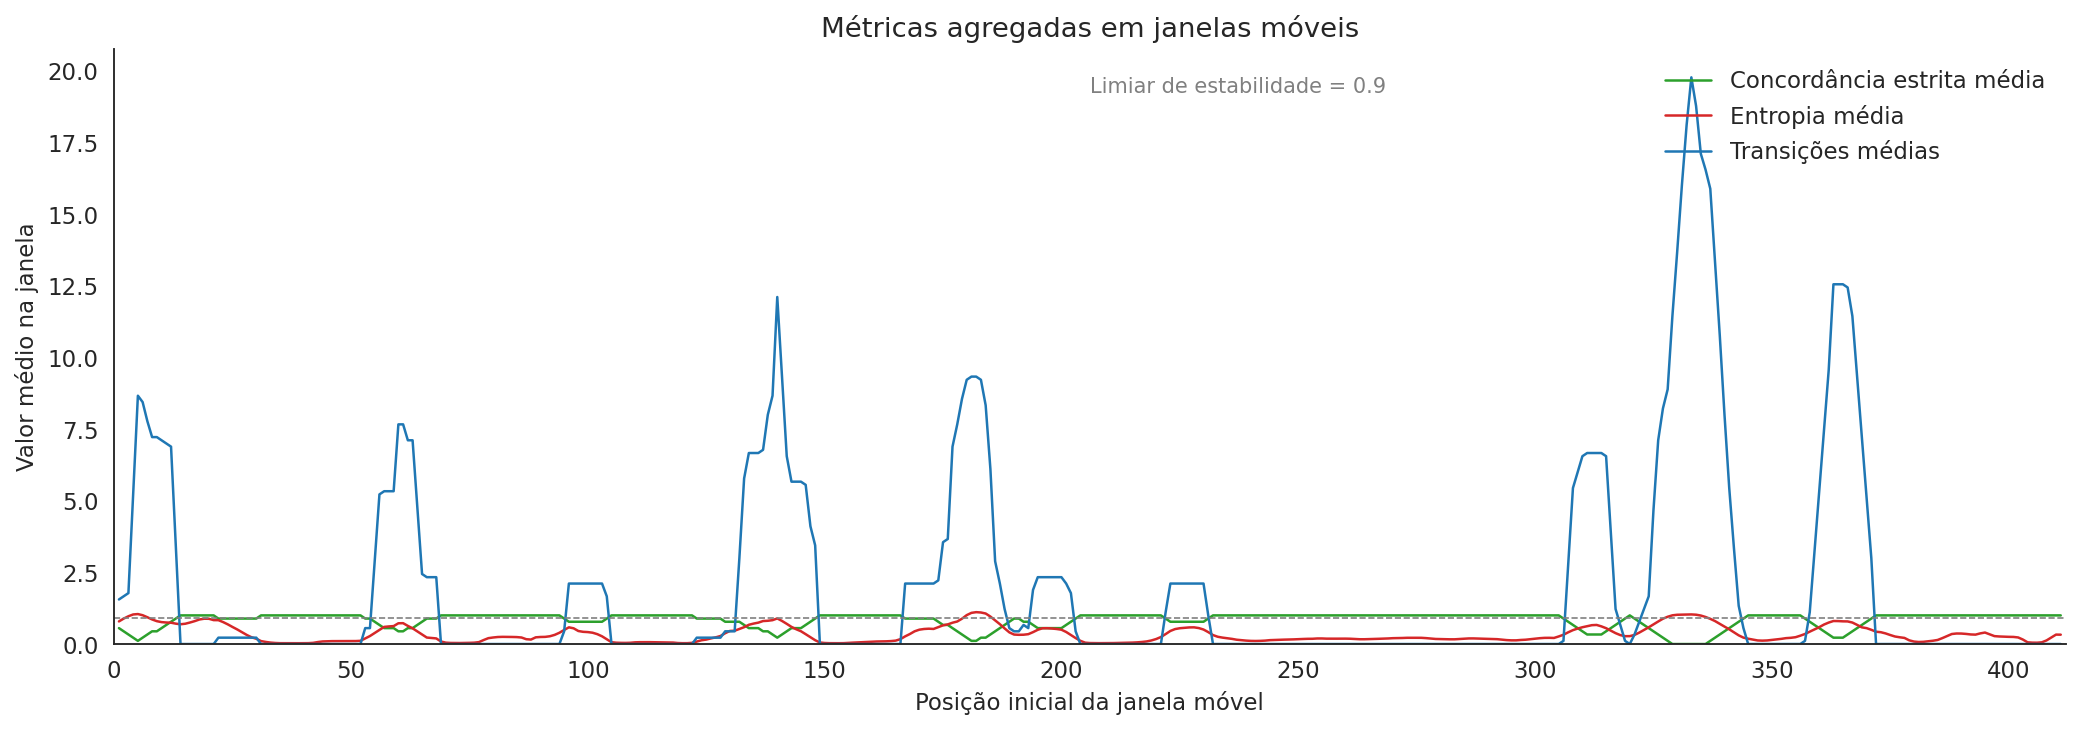

In [8]:
# Gráfico de métricas agregadas por janela móvel
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 0.9,
    'lines.linewidth': 1.2,
    'figure.dpi': 150,
    'axes.grid': False
})
sns.set_style('white')
fig_lines, ax = plt.subplots(figsize=(14, 5))
# Plot das métricas
ax.plot(df_janela['start'], df_janela['media_concordancia_estrita'], label='Concordância estrita média', color='#2ca02c')
ax.plot(df_janela['start'], df_janela['media_entropia'], label='Entropia média', color='#d62728')
ax.plot(df_janela['start'], df_janela['media_transicoes'], label='Transições médias', color='#1f77b4')
fig_lines.color_cache = plt.get_cmap('viridis')
# Rótulos e título
ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Valor médio na janela')
ax.set_title('Métricas agregadas em janelas móveis')
# Definir limites para garantir 0 nas margens (zero colado aos eixos)
ax.set_xlim(0, df_janela['start'].max() + 1)
ymax = max(df_janela[['media_concordancia_estrita', 'media_entropia', 'media_transicoes']].max()) * 1.05
ax.set_ylim(0, ymax)
# Limpar espinhas superiores/direitas e posicionar espinhas esquerda/inferior coladas ao 0
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
# Ticks externos e legenda simples
ax.tick_params(axis='both', which='both', direction='out', length=4)
ax.legend(frameon=False, loc='upper right')
# Limiar de referência
ax.axhline(0.9, color='gray', linestyle='--', linewidth=0.8)
ax.text(0.5, 0.92, 'Limiar de estabilidade = 0.9', transform=ax.transAxes, ha='left', va='bottom', color='gray', fontsize=10)
fig_lines.tight_layout()
plt.show()

## Detalhes da agregação em janelas móveis
Esta célula realiza a agregação das métricas calculadas por posição em janelas móveis ao longo da proteína. Para cada janela (exemplo: 9 resíduos), são calculadas as médias das principais métricas.

**Tabela gerada (`df_janela`):**
- `start`: posição inicial da janela na sequência de referência.
- `end`: posição final da janela.
- `media_concordancia_estrita`: média da concordância estrita na janela.
- `media_entropia`: média da entropia de Shannon na janela.
- `media_similaridade_cosseno`: média das similaridades de cosseno entre variantes nas posições da janela.
- `media_transicoes`: média das transições de estado secundário entre variantes por posição na janela.
- (`media_kl_*`): colunas opcionais agregadas caso métricas KL estejam disponíveis no `df_metricas`.

Essas médias suavizam o ruído posição a posição e ajudam a identificar regiões estáveis, divergentes ou potencialmente relevantes para função ou fenótipo. Ajuste `window_size` e `window_step` para focalizar segmentos mais curtos ou mais longos.

## Detalhes da visualização das métricas agregadas
Esta célula gera gráficos de linha para as principais métricas agregadas em janelas móveis ao longo da proteína.

**Gráficos gerados:**
- **Concordância estrita média**: mostra, para cada janela, a proporção de posições em que todas as variantes concordam no estado secundário (H/E/C). Valores próximos de 1 indicam alta estabilidade estrutural; valores baixos indicam regiões divergentes.
- **Entropia média**: indica o grau de incerteza ou dispersão das probabilidades dos estados secundários entre variantes. Valores altos sugerem maior discordância ou variabilidade estrutural.
- **Transições médias**: mostra o número médio de mudanças de estado secundário entre variantes por posição na janela. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.

Esses gráficos permitem identificar rapidamente regiões estáveis, divergentes e potenciais pontos críticos funcionais ou estruturais na proteína.

**Gráfico 1: Métricas agregadas em janelas móveis**
Este gráfico mostra, ao longo da proteína, as médias das principais métricas calculadas em janelas móveis:
- **Concordância estrita média (verde):** Proporção de posições em que todas as variantes concordam no estado secundário. Valores altos indicam regiões estáveis.
- **Entropia média (vermelho):** Mede a incerteza/dispersão das probabilidades dos estados secundários. Valores altos indicam maior divergência entre variantes.
- **Transições médias (azul):** Número médio de mudanças de estado secundário entre variantes por posição. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.
A linha cinza tracejada indica o limiar de estabilidade (0,9).

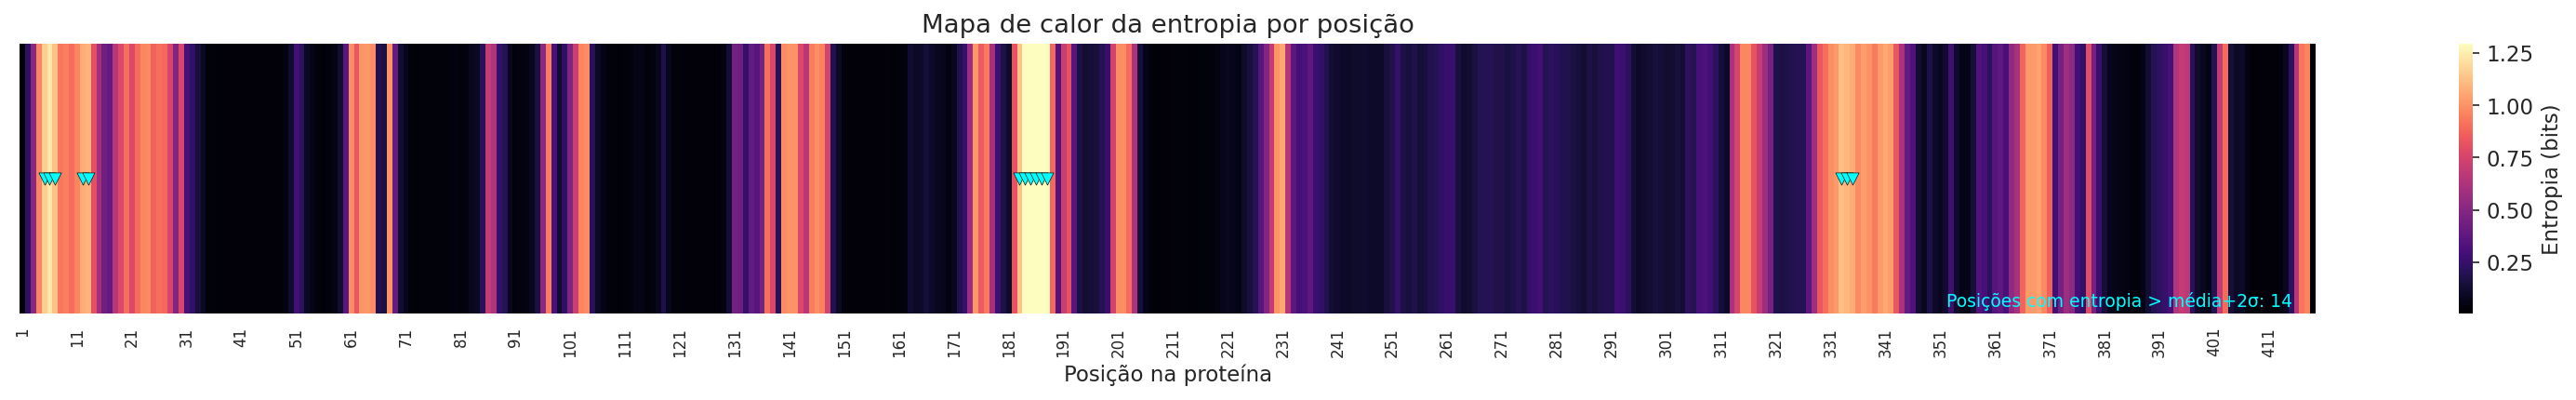

In [73]:
# Heatmap horizontal da entropia por posição com números das posições na vertical
fig_heatmap, ax = plt.subplots(figsize=(max(8, len(df_metricas) / 20), 3))  # figura larga para leitura horizontal
sns.set_style('white')
# Converter para array 1 x N (heatmap horizontal)
ent = df_metricas['entropia'].values.reshape(1, -1)
# Limites robustos para a cor (evita que outliers comprimam a escala)
vmin = np.nanmin(ent)
vmax = np.nanpercentile(ent, 99)
# Plot do heatmap (1 x N)
im = sns.heatmap(ent, cmap='magma', cbar_kws={'label': 'Entropia (bits)'}, ax=ax, vmin=vmin, vmax=vmax, yticklabels=False)
# Ajustes dos ticks no eixo x
n = ent.shape[1]
step = 10 if n > 200 else (5 if n > 100 else (2 if n > 50 else 1))
xticks = np.arange(0, n, step)
ax.set_xticks(xticks + 0.5)
ax.set_xticklabels((xticks + 1).tolist(), rotation=90, fontsize=8)
ax.set_xlabel('Posição na proteína')
ax.set_title('Mapa de calor da entropia por posição')
# Remover bordas desnecessárias
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
# Identificar posições de alta entropia
mean_e = np.nanmean(ent)
std_e = np.nanstd(ent)
threshold = mean_e + 2 * std_e
high_idx = np.where(ent.flatten() > threshold)[0]
if high_idx.size > 0:
    ax.scatter(high_idx + 0.5, np.repeat(0.5, high_idx.size), marker='v', color='cyan', s=40, edgecolor='k', linewidth=0.3, zorder=10)
    ax.text(0.99, 0.01, f'Posições com entropia > média+2σ: {len(high_idx)}', transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color='cyan')
fig_heatmap.tight_layout()
plt.show()

**Gráfico 2: Mapa de calor da entropia por posição (vertical)**
Este gráfico apresenta a entropia (incerteza/divergência) das probabilidades dos estados secundários em cada posição da proteína, com as posições dispostas verticalmente para facilitar a leitura em sequências longas.
- O eixo y representa a posição na sequência (resíduos); o eixo x é apenas a coluna do heatmap.
- Tons mais escuros representam maior entropia (maior discordância entre variantes); tons claros indicam maior consenso e estabilidade estrutural.
- O mapa usa limites robustos de cor (percentil 99) para evitar compressão por outliers.
- Posições de 'alta entropia' (definidas como entropia > média + 2σ) são marcadas com triângulos cianos à direita do heatmap; o contador informa quantas posições excedem esse limiar.

Interpretação prática: posições verticais com cor escura e marcador ciano são hotspots de variáveis estrutu- ramente relevantes e merecem investigação adicional (mutações, ligação, dominios).

In [65]:
# Célula de exportação: salva resultados e figuras para pastas 'results/' e 'figures/'
import os
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Salvar dataframes principais
df_metricas.to_csv(os.path.join('results', 'df_metricas.csv'), index=False)
df_janela.to_csv(os.path.join('results', 'df_janela.csv'), index=False)
print('Dataframes salvos em results/')

# Salvar as figuras atualmente no estado (tenta salvar a figura ativa)
try:
    fig_lines.savefig(os.path.join('figures', 'metrica_janelas.png'), bbox_inches='tight')
    print('Figura de linhas salva em figures/metrica_janelas.png')
except NameError:
    print('Figura de linhas não encontrada (variável fig_lines). Rode a célula de plotagem antes de exportar).')

try:
    fig_heatmap.savefig(os.path.join('figures', 'heatmap_entropia.png'), bbox_inches='tight')
    print('Heatmap salvo em figures/heatmap_entropia.png')
except NameError:
    print('Heatmap não encontrado (variável fig_heatmap). Rode a célula de heatmap antes de exportar).')

try:
    fig_trans.savefig(os.path.join('figures', 'transicoes_barras.png'), bbox_inches='tight')
    print('Gráfico de transições salvo em figures/transicoes_barras.png')
except NameError:
    print('Gráfico de transições não encontrado (variável fig_trans). Rode a célula de barras antes de exportar).')

Dataframes salvos em results/
Figura de linhas salva em figures/metrica_janelas.png
Figura de linhas salva em figures/metrica_janelas.png
Heatmap salvo em figures/heatmap_entropia.png
Heatmap salvo em figures/heatmap_entropia.png
Gráfico de transições salvo em figures/transicoes_barras.png
Gráfico de transições salvo em figures/transicoes_barras.png


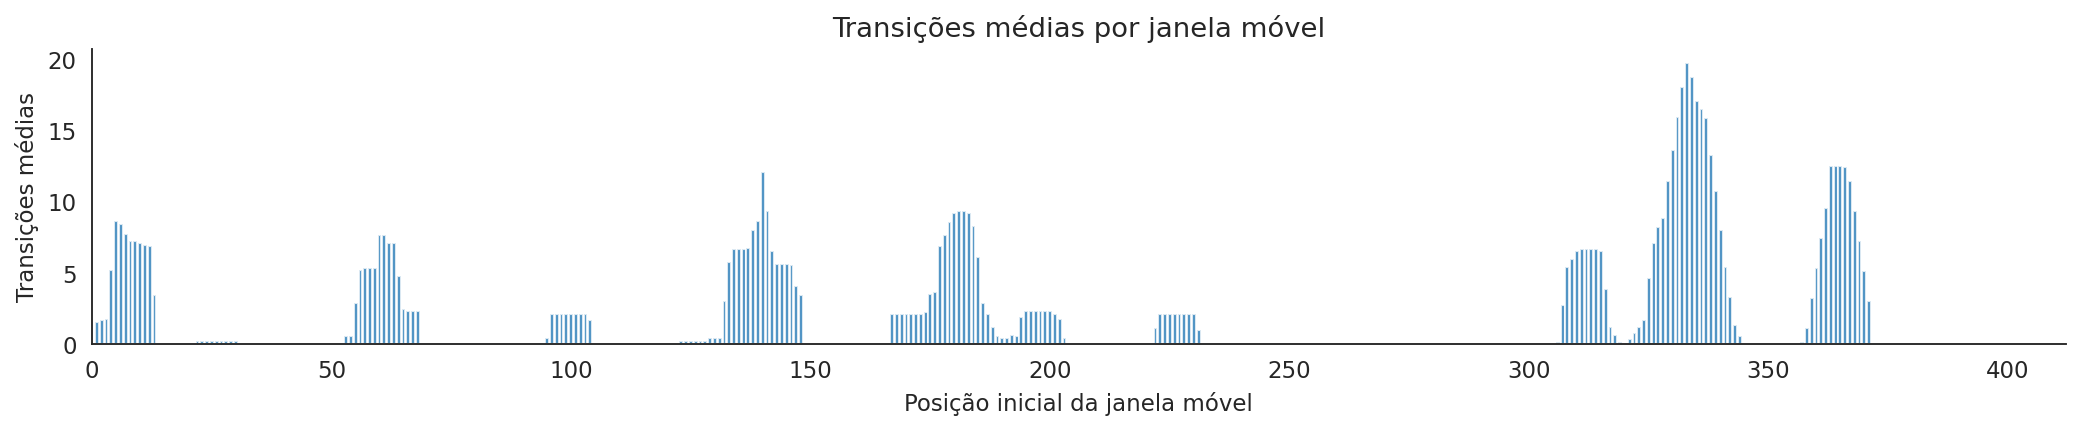

In [74]:
# Barras de transições médias por janela móvel
sns.set_style('white')
fig_trans, ax = plt.subplots(figsize=(14, 3))
ax.bar(df_janela['start'], df_janela['media_transicoes'], color='#1f77b4', alpha=0.8)
ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Transições médias')
ax.set_title('Transições médias por janela móvel')
ax.set_xlim(0, df_janela['start'].max() + 1)
ax.set_ylim(0, df_janela['media_transicoes'].max() * 1.05)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.tick_params(axis='both', which='both', direction='out', length=4)
fig_trans.tight_layout()
plt.show()

In [67]:
# 1) KL divergence por posição (referência -> cada variante): média e máximo
eps = 1e-8
kl_mean_list = []
kl_max_list = []
kl_consensus_mean_list = []
for i, prob_row in enumerate(prob_matrix):
    p_ref = np.array([df_ref.iloc[i]['P_C'], df_ref.iloc[i]['P_H'], df_ref.iloc[i]['P_E']], dtype=float)
    p_ref = np.clip(p_ref, eps, 1.0)
    p_ref = p_ref / p_ref.sum()
    consensus = np.array([df_metricas.loc[i, 'media_P_C'], df_metricas.loc[i, 'media_P_H'], df_metricas.loc[i, 'media_P_E']], dtype=float)
    consensus = np.clip(consensus, eps, 1.0)
    consensus = consensus / consensus.sum()
    kls = []
    kls_cons = []
    for v in prob_row:
        p_var = np.array([v['P_C'], v['P_H'], v['P_E']], dtype=float)
        p_var = np.clip(p_var, eps, 1.0)
        p_var = p_var / p_var.sum()
        k = entropy(p_ref, p_var, base=2)
        k_cons = entropy(consensus, p_var, base=2)
        kls.append(k)
        kls_cons.append(k_cons)
    kl_mean_list.append(float(np.mean(kls)))
    kl_max_list.append(float(np.max(kls)))
    kl_consensus_mean_list.append(float(np.mean(kls_cons)))
df_metricas['kl_mean_ref_to_var'] = kl_mean_list
df_metricas['kl_max_ref_to_var'] = kl_max_list
df_metricas['kl_mean_consensus_to_var'] = kl_consensus_mean_list
df_janela = aggregate_window_metrics(df_metricas, window_size=window_size, step=window_step)
print('KL calculado e df_janela atualizado com métricas KL.')
df_metricas.head()

KL calculado e df_janela atualizado com métricas KL.


,pos,aa_ref,concordancia_estrita,media_P_C,media_P_H,media_P_E,entropia,media_similaridade_cosseno,transicoes,kl_mean_ref_to_var,kl_max_ref_to_var,kl_mean_consensus_to_var
0,1,M,1.0,0.999000,0.000750,0.000000,0.008869,1.000000,0,0.003792,0.015166,0.002804
1,2,G,1.0,0.956778,0.025167,0.006833,0.230322,0.999954,0,0.002647,0.011445,0.001427
2,3,N,1.0,0.904861,0.076583,0.016667,0.511082,0.998845,0,0.011700,0.058859,0.010587
3,4,R,1.0,0.750500,0.176056,0.051944,0.963618,0.981453,0,0.056719,0.283659,0.059590
4,5,S,0.0,0.627278,0.281083,0.055833,1.159922,0.949515,2,0.094181,0.492988,0.097470


In [68]:
# 2) Jaccard de segmentos H/E por variante (comparar segmentos da referência com cada variante)
def get_segments_from_ss(ss_series, state):
    segments = []
    start = None
    for idx, s in enumerate(ss_series, start=1):
        if s == state and start is None:
            start = idx
        if s != state and start is not None:
            segments.append((start, idx-1))
            start = None
    if start is not None:
        segments.append((start, len(ss_series)))
    return segments

# construir lista de SS por variante (usando ss_matrix construída anteriormente)
ss_by_variant = {name: [row[j] for row in ss_matrix] for j, name in enumerate(variant_names)}
# referência
ref_ss = ss_by_variant[ref_name]
segments = []
for state in ['H','E']:
    segs = get_segments_from_ss(ref_ss, state)
    for seg_id, (sstart, send) in enumerate(segs, start=1):
        seg_positions = set(range(sstart, send+1))
        for var in variant_names:
            var_positions = set([i+1 for i, x in enumerate(ss_by_variant[var]) if x == state])
            inter = len(seg_positions & var_positions)
            uni = len(seg_positions | var_positions)
            jacc = inter / uni if uni > 0 else np.nan
            segments.append({
                'segment_id': f'ref_{state}_{seg_id}',
                'state': state,
                'start': sstart,
                'end': send,
                'ref_len': send - sstart + 1,
                'variant': var,
                'jaccard': jacc
            })

df_segments_jaccard = pd.DataFrame(segments)
# resumo por segmento (média e desvio)
df_seg_summary = df_segments_jaccard.groupby(['segment_id','state','start','end','ref_len']).jaccard.agg(['mean','std','count']).reset_index().rename(columns={'mean':'jaccard_mean','std':'jaccard_std'})
print('Jaccard por segmento gerado: df_segments_jaccard e resumo em df_seg_summary')
df_segments_jaccard.head()

Jaccard por segmento gerado: df_segments_jaccard e resumo em df_seg_summary


,segment_id,state,start,end,ref_len,variant,jaccard
0,ref_H_1,H,12,13,2,NM_000797.4,0.008163
1,ref_H_1,H,12,13,2,AY151027.1,0.000000
2,ref_H_1,H,12,13,2,AY151028.1,0.000000
3,ref_H_1,H,12,13,2,AY151029.1,0.000000
4,ref_H_1,H,12,13,2,AY151030.1,0.000000


In [69]:
# Verificação rápida das figuras principais antes da exportação
required_figs = {'fig_lines': 'gráfico de linhas', 'fig_heatmap': 'heatmap de entropia', 'fig_trans': 'barras de transições'}
missing = [alias for alias in required_figs if alias not in globals()]
if missing:
    print('Atenção: gere as figuras antes de exportar (células anteriores). Faltando:', ', '.join(missing))
else:
    print('Figuras prontas para exportação:', ', '.join(required_figs[name] for name in required_figs))

Figuras prontas para exportação: gráfico de linhas, heatmap de entropia, barras de transições


**Gráfico 3: Transições médias por janela móvel**
Este gráfico mostra, para cada janela móvel ao longo da proteína, o número médio de transições de estado secundário entre variantes.
- Barras mais altas indicam regiões com maior discordância estrutural entre variantes (mais mudanças de H↔E/C).
- Barras baixas indicam regiões mais estáveis e conservadas.
Este gráfico é útil para identificar hotspots de variabilidade estrutural e potenciais regiões de interesse funcional.